<a href="https://colab.research.google.com/github/Thienbuu/practice_dl_project/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai2

     |████████████████████████████████| 194kB 7.0MB/s 


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!rm -rf data/train
!rm -rf data/test
!mkdir -p data/train
!mkdir -p data/test

In [ ]:
!kaggle competitions download -c digit-recognizer -p data

 55% 5.00M/9.16M [00:00<00:00, 21.6MB/s]
100% 9.16M/9.16M [00:00<00:00, 30.6MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 76.1MB/s]
 82% 5.00M/6.09M [00:00<00:00, 23.7MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.2MB/s]


In [ ]:
!unzip data/test.csv.zip
!unzip data/train.csv.zip

Archive:  data/test.csv.zip
  inflating: test.csv                
Archive:  data/train.csv.zip
  inflating: train.csv               


In [ ]:
from fastai2.vision.all import *
import pandas as pd

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
print('train shape:', train.shape)
print('test shape:', test.shape)

train shape: (42000, 785)
test shape: (28000, 784)


In [ ]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cols = test.columns
def pixel2image(row, index, path_name):
  pixels =  row[cols].to_numpy(dtype=np.uint8)
  pixels = pixels.reshape(28, 28)
  img = Image.fromarray(pixels)
  img_path = 'data/{0}/{1}.jpg'.format(path_name, index)
  img.convert('RGB').save(img_path)
  return img_path


In [ ]:
fname = []
for idx, row in train.iterrows():
  fname.append(pixel2image(row, idx, 'train'))

In [ ]:
fname_series = pd.Series(data=fname, name='fname')
train_df = pd.concat([train['label'], fname_series], axis=1)
train_df = train_df.sort_values(by=['label'])
train_df.head()

,label,fname
9747,0,data/train/9747.jpg
4103,0,data/train/4103.jpg
27801,0,data/train/27801.jpg
27799,0,data/train/27799.jpg
37354,0,data/train/37354.jpg


In [ ]:
labels = train_df['label'].unique().tolist()
valid = []
for label in labels:
   label_len = len(train_df[train_df['label'] == label])
   valid_len = int(label_len * 0.1)
   label_valid = np.concatenate([np.zeros(valid_len, dtype=bool),
                                  np.ones(label_len - valid_len, dtype=bool)])
   np.random.shuffle(label_valid)
   valid += list(label_valid)

train_df['valid']  = valid

In [ ]:
for label in labels:
  label_df = train_df[train_df['label'] == label]
  print('label: {0}, train: {1}, valid {2}'.format( 
        label,
        label_df[label_df['valid'] == True].shape[0],
        label_df[label_df['valid'] == False].shape[0]))

label: 0, train: 3719, valid 413
label: 1, train: 4216, valid 468
label: 2, train: 3760, valid 417
label: 3, train: 3916, valid 435
label: 4, train: 3665, valid 407
label: 5, train: 3416, valid 379
label: 6, train: 3724, valid 413
label: 7, train: 3961, valid 440
label: 8, train: 3657, valid 406
label: 9, train: 3770, valid 418


In [ ]:
fname = []
for idx, row in test.iterrows():
  fname.append(pixel2image(row, idx, 'test'))

In [ ]:
fname_series = pd.Series(data=fname, name='fname')
test_df = pd.concat([test, fname_series], axis=1)
test_df = test_df[['fname']]
test_df.head()

,fname
0,data/test/0.jpg
1,data/test/1.jpg
2,data/test/2.jpg
3,data/test/3.jpg
4,data/test/4.jpg


In [ ]:
path = Path('')

In [ ]:
(path/'data/train').ls()

(#42000) [Path('data/train/11591.jpg'),Path('data/train/37956.jpg'),Path('data/train/20230.jpg'),Path('data/train/13982.jpg'),Path('data/train/35361.jpg'),Path('data/train/22802.jpg'),Path('data/train/23399.jpg'),Path('data/train/16647.jpg'),Path('data/train/10552.jpg'),Path('data/train/3366.jpg')...]

In [ ]:
def get_x(r): return Path(r['fname'])
def get_y(r): return str(r['label'])
def splitter(df): 
  train = df.index[~df['valid']].tolist()
  valid = df.index[df['valid']].tolist()
  return train, valid

def get_dls(bs, item_tfms_size, batch_tfms_size):
  dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), 
                     splitter=splitter, get_x=get_x, get_y=get_y,
                     batch_tfms = aug_transforms(size=batch_tfms_size, 
                                                 min_scale=0.75, 
                                                 do_flip=False, 
                                                 max_rotate=10, 
                                                 max_zoom=1.3, 
                                                 max_lighting=0.2, 
                                                 p_affine=0.75)
                     )
  return dblock.dataloaders(train_df)

In [ ]:
dls = get_dls(64, 128, 128)

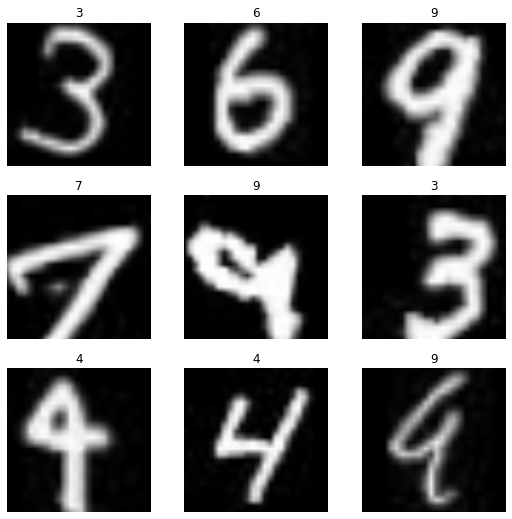

In [ ]:
dls.show_batch(nrows=3, ncols=3)

In [ ]:
learn = cnn_learner(dls, resnet50, 
                    loss_func=F.binary_cross_entropy_with_logits, 
                    metrics=accuracy_multi)

SuggestedLRs(lr_min=0.014996849000453949, lr_steep=0.006546361837536097)

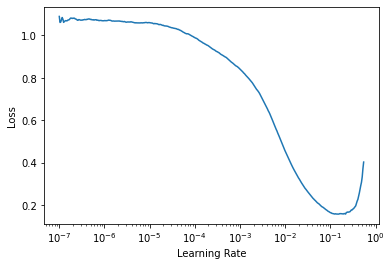

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(30, base_lr=1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.708453,0.452861,0.805246,02:02
1,0.286426,0.088143,0.967143,02:02
2,0.127053,0.045190,0.984306,02:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.035119,0.013110,0.995612,02:10
1,0.021622,0.012489,0.996054,02:10
2,0.018326,0.010514,0.996540,02:10
3,0.017732,0.019583,0.993807,02:10
4,0.022244,0.013489,0.995943,02:10
5,0.023673,0.028464,0.991776,02:10
6,0.024709,0.013557,0.995884,02:10
7,0.021110,0.020964,0.993893,02:10
8,0.021468,0.026937,0.991940,02:10
9,0.017215,0.014698,0.995779,02:10


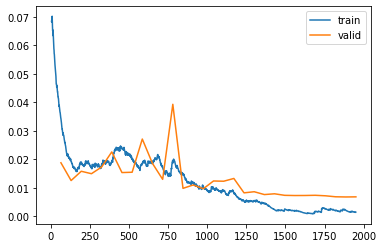

In [ ]:
learn.recorder.plot_loss()

In [ ]:
test_img = get_image_files('data/test')

In [ ]:
test_dl = learn.dls.test_dl(test_img)

In [ ]:
preds, targets = learn.tta(dl=test_dl)
print(preds[0].tolist())

preds_1, targets_1 = learn.get_preds(dl=test_dl)
print(preds_1[0].tolist())

[-19.378931045532227,
 -18.578617095947266,
 -17.99826431274414,
 16.55066680908203,
 -19.823884963989258,
 -18.016891479492188,
 -19.388639450073242,
 -19.76517105102539,
 -19.333406448364258,
 -20.23206901550293]

In [ ]:
class_score = np.argmax(preds, axis=1)

In [ ]:
image_ids = [img.stem for img in test_img]

In [ ]:
submission = pd.DataFrame(columns=['ImageId', 'Label'])

submission['ImageId'] = image_ids
submission['Label'] = class_score

submission['ImageId'] = submission['ImageId'].astype('int')
submission = submission.sort_values(by=['ImageId'])
submission['ImageId'] += 1

submission.info()

In [ ]:
submission.head()

,ImageId,Label
13092,1,2
10477,2,0
8998,3,9
27409,4,0
27337,5,3


In [ ]:
submission.to_csv('third_submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c digit-recognizer -f third_submission.csv -m "second submission"

100% 208k/208k [00:02<00:00, 81.2kB/s]
Successfully submitted to Digit Recognizer